# Time-series prediction
### My take on becoming rich with ML in trading 🤑
Here, we compare 2 RNNs. One is which is famous among the user, LSTM, and other which is regaining popularity, Echo State Network. This notebook is related to this [blog post](https://ikespand.github.io/posts/ml-for-stock-market-1/)

## I. Obtaining data
Here, we get the data from Yahoo Finance API (yfinance package) which has some limitation for bulk and daily usage. So restricting the notebook to examination purpose.

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

C:\Users\PC\anaconda3\envs\py38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\PC\anaconda3\envs\py38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\PC\anaconda3\envs\py38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


Create the instance for the given ticker

In [2]:
tikr = yf.Ticker("AMZN")
tikr_history = tikr.history(start="2012-08-14", end="2022-09-01", interval="1d")
#tikr_history = tikr.history(period="1mo", interval="5m")
#tikr_history = tikr.history(period="max")

We can run sentiment analysis if we want on the current news.

In [3]:
#print(tikr.news)
#print(tikr.info)

In [4]:
print("Shape of df", tikr_history.shape)
tikr_history.head(5)

Shape of df (2530, 7)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-08-13,11.6115,11.7185,11.5500,11.6220,39946000,0,0.0
2012-08-14,11.7355,11.8360,11.6310,11.6595,55020000,0,0.0
2012-08-15,11.6130,11.9070,11.6125,11.8710,65294000,0,0.0
2012-08-16,11.8860,12.1410,11.8100,12.0775,86242000,0,0.0
2012-08-17,12.0300,12.1675,12.0235,12.0585,61716000,0,0.0


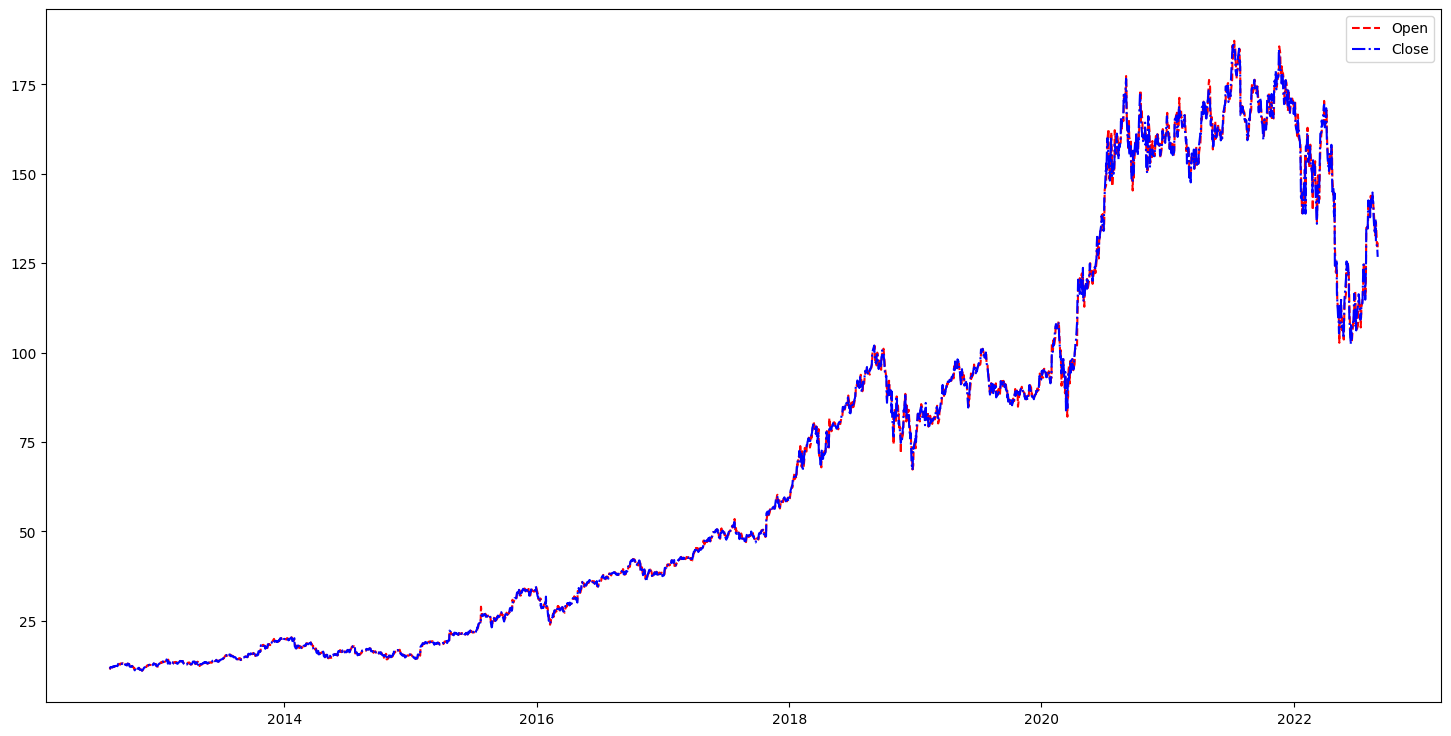

In [5]:
# Visualise the bid_price predictions
plt.figure(figsize = (18,9))
plt.plot(tikr_history['Open'], color = 'red', linestyle="--", label = 'Open')
plt.plot(tikr_history['Close'], color = 'blue', linestyle="-.", label = 'Close')
plt.legend()
plt.show()

#### Let's focus on limited columns
We will consider only 4 variables (Open, High, Low, Close), therefore dropping reamining columns.

In [6]:
tikr_history = tikr_history.drop(["Dividends", "Stock Splits", "Volume"], axis=1)
tikr_history.head(5)

,Open,High,Low,Close
Date,,,,
2012-08-13,11.6115,11.7185,11.5500,11.6220
2012-08-14,11.7355,11.8360,11.6310,11.6595
2012-08-15,11.6130,11.9070,11.6125,11.8710
2012-08-16,11.8860,12.1410,11.8100,12.0775
2012-08-17,12.0300,12.1675,12.0235,12.0585


## II. Problem statement: Machine Learning for prediction
We have historical data where we know what has happened in past 10 years on daily basis. We have 4 variables on a given day which are Open, High, Low and Close. Our aim is to predict the Open price on the next day.

In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout,Activation

### 1. Deep recurrent neural network with LSMT

#### Data prepartion
- Separating the train and test data with an 80-20% split
- Scaling the data

In [8]:
n_train_rows = int(tikr_history.shape[0]*.8)-1

# Split into train and test sets but keep all 9 columns
train = tikr_history.iloc[:n_train_rows, :]
test = tikr_history.iloc[n_train_rows:, :]

# The total rows of the two datasets should equal the total amount of rows in your CSV
print("train.shape", train.shape)
print("test.shape", test.shape)

train.shape (2023, 4)
test.shape (507, 4)


In [9]:
# Normalise features
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)
test_set_scaled = sc.fit_transform(test.values)
print(f"training set max is {training_set_scaled.max()} and min is {training_set_scaled.min()}")
print(f"testing set max is {test_set_scaled.max()} and min is {test_set_scaled.min()}")

training set max is 1.0 and min is 0.0
testing set max is 1.0 and min is 0.0


Rearranging the data: LSTM requires data as per -> samples * time_history_steps * features

In [10]:
# How many days of historical data can we use to predict the next one
n_past_steps = 7
n_future_steps = 1

# Prepare the training data
x_train = []
y_train = []

for i in range(n_past_steps, training_set_scaled.shape[0]- n_future_steps + 1):
    x_train.append(training_set_scaled[i-n_past_steps:i, :]) # All available columns as inputs
    y_train.append(training_set_scaled[i:i + n_future_steps, 0]) # Taking only Open price as desired output

x_train, y_train = np.array(x_train), np.array(y_train)
print("x_train.shape, y_train.shape", x_train.shape, y_train.shape)

# Prepare the test data
x_test = []
y_test = []

for i in range(n_past_steps, test_set_scaled.shape[0]- n_future_steps + 1):
    x_test.append(test_set_scaled[i-n_past_steps:i, :]) # All available columns as inputs
    y_test.append(test_set_scaled[i:i + n_future_steps, 0]) # Taking only Open price as desired output

x_test, y_test = np.array(x_test), np.array(y_test)
print("x_test.shape, y_test.shape", x_test.shape, y_test.shape)

x_train.shape, y_train.shape (2016, 7, 4) (2016, 1)
x_test.shape, y_test.shape (500, 7, 4) (500, 1)


Observe above, the shape of `x` and `y`. Let's double check: If, current x(t=0) has 3 values then its y(t=0) will be equal to the last element(s) in x(t=1) 

In [11]:
# easy to validate if `n_future_steps` = 1
y_train[0]-x_train[1][-n_future_steps][0]

array([0.])

In [12]:
dropout_rate=0.2
epochs=5
batch_size=32
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, input_shape=(x_train.shape[1], x_train.shape[2]), activation='relu', return_sequences = True))
#lstm_model.add(LSTM(units=28, input_shape=(x_train.shape[1], x_train.shape[2]), activation='relu', return_sequences = True))
lstm_model.add(LSTM(units=16))
lstm_model.add(Dropout(dropout_rate))
lstm_model.add(Dense(units=y_train.shape[1]))
lstm_model.compile(loss="mse", optimizer="adam")
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 64)             17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 22,865
Trainable params: 22,865
Non-trainable params: 0
_________________________________________________________________


In [13]:
%%time
model_training_his = lstm_model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_split=0.2)

Epoch 1/5
51/51 [==============================] - 2s 36ms/step - loss: 0.0139 - val_loss: 0.0042
Epoch 2/5
51/51 [==============================] - 1s 26ms/step - loss: 0.0011 - val_loss: 8.6302e-04
Epoch 3/5
51/51 [==============================] - 1s 26ms/step - loss: 0.0011 - val_loss: 9.0979e-04
Epoch 4/5
51/51 [==============================] - 1s 26ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 5/5
51/51 [==============================] - 1s 27ms/step - loss: 9.5598e-04 - val_loss: 8.3545e-04
CPU times: total: 17.3 s
Wall time: 11 s


In [14]:
# Evaluate the model on the test data using `evaluate`
test_metrics = lstm_model.evaluate(x_test, y_test, batch_size=batch_size)
print('test loss, test acc:', test_metrics)
#lstm_model.save("multiple_features_"+str(steps)+"_steps_"+str(epochs)+"_epochs.h5")
print("x_test.shape, y_test.shape",x_train.shape, y_train.shape)

16/16 [==============================] - 0s 4ms/step - loss: 0.0074
test loss, test acc: 0.0074326880276203156
x_test.shape, y_test.shape (2016, 7, 4) (2016, 1)


In [15]:
# Predict values from test data trained using training data and reverse transform
y_hat_scaled = lstm_model.predict(x_test)
# Following part just to perform inverse transform as it expect 4 columns but we have only 1. So fooling it (or me?!)
y_hat_scaled_4 = np.repeat(y_hat_scaled, 4, axis=1)
y_hat_lstm = sc.inverse_transform(y_hat_scaled_4)[:,0]

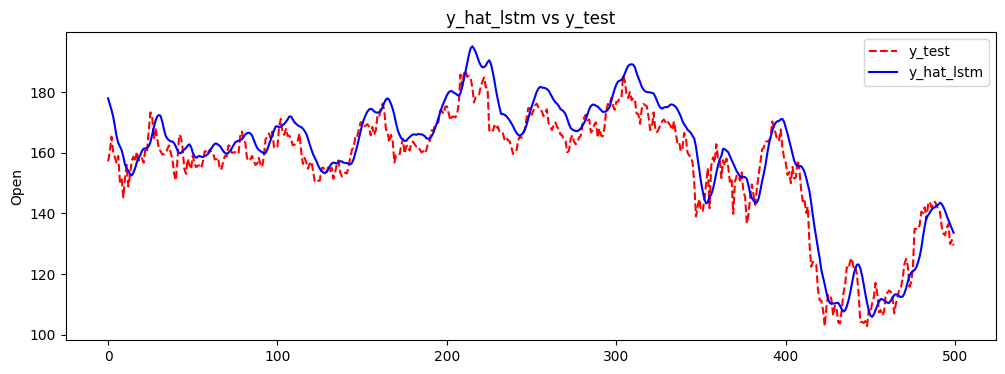

In [16]:
y_test_orig = test[n_past_steps:].reset_index(drop=True)
# Visualise the ask_price predictions
plt.figure(figsize = (12, 4))
plt.plot(y_test_orig['Open'], color = 'red', linestyle = "--", label = 'y_test')
plt.plot(y_hat_lstm, color = 'blue', label = 'y_hat_lstm')
plt.title('y_hat_lstm vs y_test')
plt.ylabel('Open')
plt.legend()
plt.show()

Results look great (but they are not). Basically, there is always a lag between the GT and prediction. The values of GT are keep getting updates, thereby the prediction lies close to the GT but shifted.

In [17]:
x_train[-50:].shape

(50, 7, 4)

### 2. Echo State Network (ESN)
Here, the implementation is slightly different because of input data requirement with the library. However, we can have similar comparision and interface.

In [18]:
from easyesn import PredictionESN

Using Numpy backend.


In [19]:
x_train_esn = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
y_train_esn = y_train
print("x_train_esn.shape, y_train_esn.shape", x_train_esn.shape, y_train_esn.shape)

x_test_esn = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
y_test_esn = y_test
print("x_test.shape, y_test.shape", x_test_esn.shape, y_test_esn.shape)

x_train_esn.shape, y_train_esn.shape (2016, 28) (2016, 1)
x_test.shape, y_test.shape (500, 28) (500, 1)


In [20]:
%%time
# Build the model by using PredictionESN() class
esn = PredictionESN(
    n_input = x_train_esn.shape[1],
    n_output = y_train_esn.shape[1],
    n_reservoir= 50,
    feedback=False,
    randomSeed = 42
)

# Fit the model
esn.fit(x_train_esn, y_train_esn, transientTime="Auto", verbose=1)

100% (1970 of 1970) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


CPU times: total: 203 ms
Wall time: 176 ms


0.00469637745654231

In [21]:
y_hat_esn = esn.predict(x_test_esn)


In [22]:
# Predict values from test data trained using training data and reverse transform
y_hat_esn_scaled = esn.predict(x_test_esn)
# Following part just to perform inverse transform as it expect 4 columns but we have only 1. So fooling it (or me?!)
y_hat_esn_scaled_4 = np.repeat(y_hat_esn_scaled, 4, axis=1)
y_hat_esn = sc.inverse_transform(y_hat_esn_scaled_4)[:,0]

In [23]:
print("y_test.shape, y_hat_esn.shape", y_test.shape, y_hat_esn.shape)

y_test.shape, y_hat_esn.shape (500, 1) (500,)


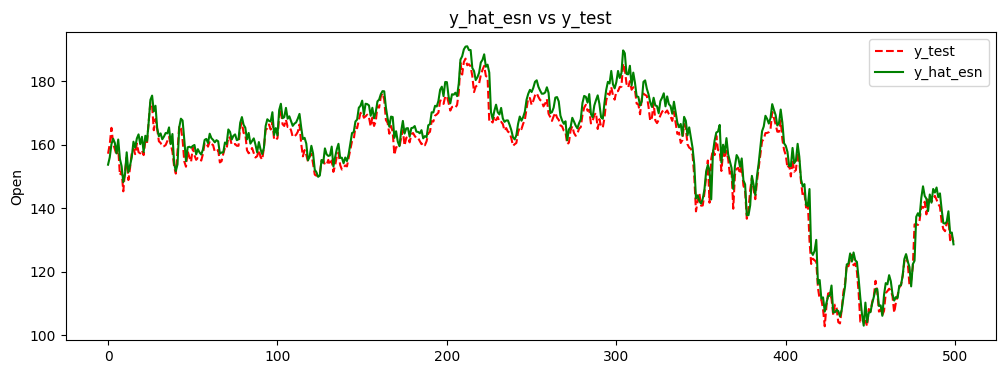

In [24]:
y_test_orig = test[n_past_steps:].reset_index(drop=True)
# Visualise the ask_price predictions
plt.figure(figsize = (12, 4))
plt.plot(y_test_orig['Open'], color = 'red', linestyle = "--", label = 'y_test')
plt.plot(y_hat_esn, color = 'green', label = 'y_hat_esn')
plt.title('y_hat_esn vs y_test')
plt.ylabel('Open')
plt.legend()
plt.show()

### Moment of truth: Comparing LSTM and ESN
Comparing both the network in a single graph.

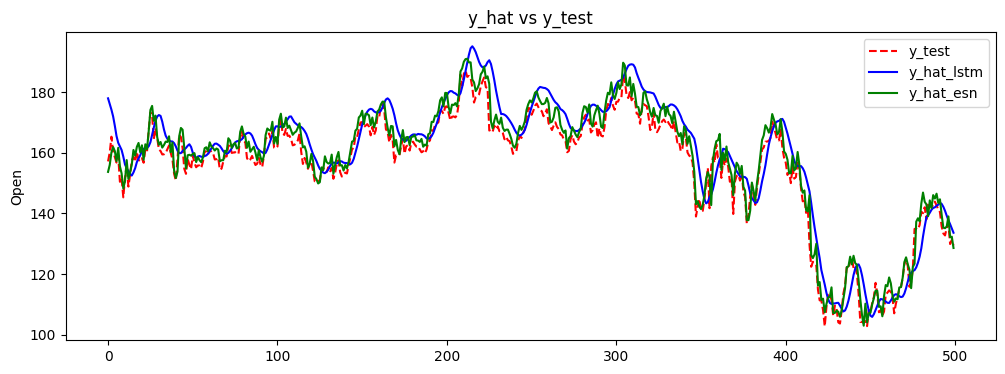

In [25]:
y_test_orig = test[n_past_steps:].reset_index(drop=True)
# Visualise the ask_price predictions
plt.figure(figsize = (12, 4))
plt.plot(y_test_orig['Open'], color = 'red', linestyle = "--", label = 'y_test')
plt.plot(y_hat_lstm, color = 'blue', label = 'y_hat_lstm')
plt.plot(y_hat_esn, color = 'green', label = 'y_hat_esn')
plt.title('y_hat vs y_test')
plt.ylabel('Open')
plt.legend()
plt.show()

Zoom-in to the last 100 values to see differences.

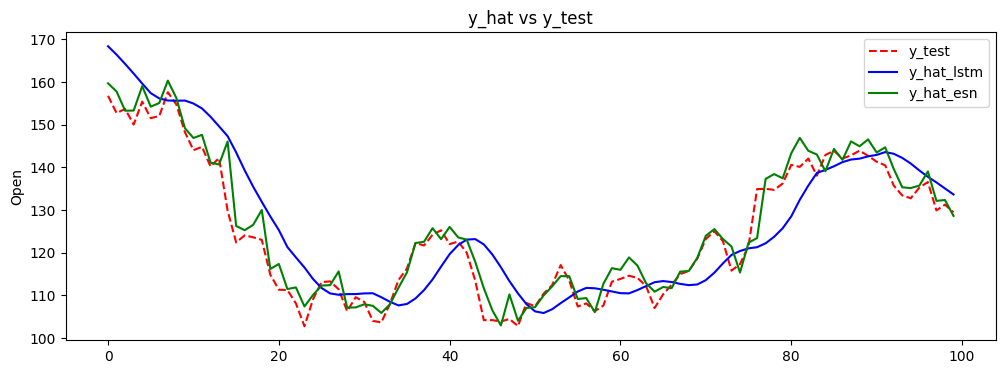

In [26]:
y_test_orig = test[n_past_steps:].reset_index(drop=True)
# Visualise the ask_price predictions
plt.figure(figsize = (12, 4))
plt.plot(y_test_orig['Open'][-100:].to_list(), color = 'red', linestyle = "--", label = 'y_test')
plt.plot(y_hat_lstm[-100:], color = 'blue', label = 'y_hat_lstm')
plt.plot(y_hat_esn[-100:], color = 'green', label = 'y_hat_esn')
plt.title('y_hat vs y_test')
plt.ylabel('Open')
plt.legend()
plt.show()

## Summary
- In both RNNs, our time horizon is limited i.e. by taking all past steps, we predict few days in advance (here only 1 day).
- Both models are shifted in some sense.
- ESN takes much lesser time to train, setup and capture the series in much better was as can be seen from above image.
- More details [on this post](https://ikespand.github.io/posts/ml-for-stock-market-1/)

END OF NOTEBOOK